In [1]:
dataroot = "img_align_celeba/"

In [2]:
from __future__ import print_function
import os, math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision
from PIL import Image
from copy import deepcopy

attributes = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 
 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 
 'Big_Lips', 'Big_Nose', 'Black_Hair', 
 'Blond_Hair', 'Blurry', 'Brown_Hair', 
 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 
 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 
 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 
 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 
 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 
 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 
 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 
 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 
 'Young']

def set_random_seed(seed=999):
    print("Random Seed: ", seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [3]:
class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, transform = None):
        '''Initialize the dataset.'''
        self.transform = transform
        self.root = dataroot
        self.attr_txt = dataroot + 'list_attr_celeba.txt'
        self._parse()
    
    def _parse(self):
        '''
        Parse the celeba text file.
        Pupulate the following private variables:
         - self.ys: A list of 1D tensors with 40 binary attribute labels.
         - self.im_paths: A list of strings (image paths).
        '''
        self.im_paths = []
        self.ys = []
        
        def _to_binary(lst):
            return torch.tensor([0 if lab == '-1' else 1 for lab in lst])
            
        with open(self.attr_txt) as f:
            for line in f:
                assert len(line.strip().split()) == 41
                fl = line.strip().split()
                if fl[0][-4:] == '.jpg': # if not header
                    self.im_paths.append(self.root + fl[0])
                    self.ys.append(_to_binary(fl[1:]))
        
    def __len__(self):
        '''Return length of the dataset.'''
        return len(self.ys)

    def __getitem__(self, index):
        '''
        Return the (image, attributes) tuple.
        This function gets called when you index the dataset.
        '''
        def img_load(index):
            imraw = Image.open(self.im_paths[index])
            im = self.transform(imraw)
            return im

        target = self.ys[index]
        return img_load(index), target

In [4]:
def nonlinearity(x):
    return x*torch.sigmoid(x)

class Block(nn.Module):
    '''
    This implements a residual block.
    It has a similar structure to the residual block used in ResNets,
    but there are a few modern modifications:
     - Different order of applying weights, activations, and normalization.
     - Swish instead of ReLU activation.
     - GroupNorm instead of BatchNorm.
    We also need to add the conditional embedding.
     
    '''
    def __init__(self, in_channels, out_channels, emb_dim=256):
        '''
        in_channels: Number of image channels in input.
        out_channels: Number of image channels in output.
        emb_dim: Length of conditional embedding vector.
        '''
        super().__init__()
            
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.norm1 = nn.GroupNorm(1, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.proj = nn.Linear(emb_dim, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, t):
        '''
        h and x have dimension B x C x H x W,
        where B is batch size,
              C is channel size,
              H is height,
              W is width.
        t is the conditional embedding.
        t has dimension B x V,
        where V is the embedding dimension.
        '''
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)
        t = self.proj(t)
        t = nonlinearity(t)
        h = h + t.unsqueeze(-1).unsqueeze(-1)

        h = nonlinearity(h)
        h = self.conv2(h)
        
        if self.in_channels != self.out_channels:
            x = self.shortcut(x)
            
        return x+h

In [5]:
class Down(nn.Module):
    ''' Downsampling block.'''
    def __init__(self, in_channels, out_channels):
        '''
        This block downsamples the feature map size by 2.
        in_channels: Number of image channels in input.
        out_channels: Number of image channels in output.
        '''
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = Block(in_channels, out_channels)

    def forward(self, x, t):
        ''' x is the feature maps; t is the conditional embeddings. '''
        x = self.pool(x) 
        x = self.conv(x, t)
        return x

class Up(nn.Module):
    ''' Upsampling block.'''
    def __init__(self, in_channels, out_channels):
        '''
        This block upsamples the feature map size by 2.
        in_channels: Number of image channels in input.
        out_channels: Number of image channels in output.
        '''
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = Block(in_channels, out_channels)

    def forward(self, x, skip_x, t):
        ''' 
        x is the feature maps; 
        skip_x is the skipp connection feature maps;
        t is the conditional embeddings.
        '''
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x, t)
        return x

The UNet class implements a condional UNet. Please fill in the missing code according to the commented directions.

In [6]:
class UNet(nn.Module):
    ''' UNet implementation of a denoising auto-encoder.'''
    def __init__(self, c_in=3, c_out=3, conditional=True, emb_dim=256):
        '''
        c_in: Number of image channels in input.
        c_out: Number of image channels in output.
        emb_dim: Length of conditional embedding vector.
        '''
        super().__init__()
        self.emb_dim = emb_dim
        self.inc = Block(c_in, 64)
        self.down1 = Down(64, 128) 
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)

        self.bot1 = Block(256, 512)
        self.bot2 = Block(512, 512)
        self.bot3 = Block(512, 512)
        self.bot4 = Block(512, 256)

        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
        self.conditional = conditional
        if conditional:
            num_classes = 4
            
            self.gender_vectors = nn.Parameter(torch.randn(num_classes, emb_dim))

    def temporal_encoding(self, timestep):
        ''' 
        This implements the sinusoidal temporal encoding for the current timestep. 
        Input timestep is a tensor of length equal to the batch size
        Output emb is a 2D tensor B x V,
            where V is the embedding dimension.
        '''
        assert len(timestep.shape) == 1
        half_dim = self.emb_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
        emb = emb.to(device=timestep.device)
        emb = timestep.float()[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if self.emb_dim % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0,1,0,0))
        return emb

    def unet_forward(self, x, t):
        # x: B x 3 x 224 x 224
        x1 = self.inc(x, t)    # x1: B x 64 x 64 x 64
        x2 = self.down1(x1, t) # x2: B x 128 x 32 x 32
        x3 = self.down2(x2, t) # x3: B x 256 x 16 x 16
        x4 = self.down3(x3, t) # x3: B x 256 x 8 x 8

        x4 = self.bot1(x4, t) # x4: B x 512 x 8 x 8
        # Removing bot2 and bot3 can save some time at the expense of quality
        x4 = self.bot2(x4, t) # x4: B x 512 x 8 x 8
        x4 = self.bot3(x4, t) # x4: B x 512 x 8 x 8
        x4 = self.bot4(x4, t) # x4: B x 256 x 8 x 8

        x = self.up1(x4, x3, t) # x: B x 128 x 16 x 16
        x = self.up2(x, x2, t)  # x: B x 64 x 32 x 32
        x = self.up3(x, x1, t)  # x: B x 64 x 64 x 64
        output = self.outc(x)   # x: B x 3 x 64 x 64
        return output
    
    def forward(self, x, t, y=None):
        '''
        x: image input
        t: integer timestep
        y: binary conditioning
        Return denoised image conditioned on the timestep t and
            class label y.
        '''
        if self.conditional:
            
            c = self.temporal_encoding(t) + self.gender_vectors[y.long()]
            
        else:
            c = self.temporal_encoding(t)
        return self.unet_forward(x, c)

In [7]:
import math

class Diffusion:
    ''' 
    Implements the Diffusion process,
    including both training and sampling.
    '''
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        
        self.beta = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.beta
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)


    def get_noisy_image(self, x_0, t, y=None):
        '''
        This function is only used for training.
        
        x_0: The input image. Dimensions: B x 3 x H x W
        t: A 1D vector of length B representing the desired timestep
          B is the batch size.
          H and W are the height and width of the input image.
        y: A 1D binary vector of length B indicating the desired gender for the input image.
        '''
        batch_size = x_0.size(0)
        epsilon = torch.randn(batch_size, 3, self.img_size, self.img_size, device=self.device)
        x_t = x_0 * self.alphas_bar[t].sqrt()[:, None, None, None] + (1 - self.alphas_bar[t]).sqrt()[:, None, None, None] * epsilon 

        return x_t, epsilon

    def sample(self, model, n, y=None):
        '''
        This function is used  to generate images.
        
       
        model: The denoising auto-encoder \epsilon_{\theta}
        n: The number of images you want to generate
        y: A 1D binary vector of size n indicating the 
            desired gender and glasses for the generated faces.
        '''
        model.eval()
        with torch.no_grad():
            x = torch.randn(n, 3, self.img_size, self.img_size, device=self.device)
            for t in reversed(range(1, self.num_timesteps)):
                if t == 0:
                    z = 0
                else:
                    z = torch.randn(n, 3, self.img_size, self.img_size, device=self.device)
                ones = torch.ones(n, device=self.device)
                epsilon_theta = model(x, t*ones, y)
                beta_t = self.beta[t]
                alpha_t = self.alphas[t]
                alpha_t_bar = self.alphas_bar[t]
                mu_theta = 1/math.sqrt(alpha_t) * (x - beta_t * epsilon_theta/math.sqrt(1-alpha_t_bar))
                x = mu_theta + math.sqrt(beta_t) * z

        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x
    
def show_images(images, **kwargs):
    plt.figure(figsize=(10, 10), dpi=80)
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    plt.imshow(im)
    plt.show()


In [8]:
class EMA:
    '''
    This class implements the Expontial Moving Average (EMA) for model weights.
    Only used for evaluation.
    Using the EMA averaged model increases the quality of generated images.
    '''
    def __init__(self, beta=0.995):
        '''
        beta is a hyperparameter.
        New model weights = beta * (old model weights) + 
                            (1 - beta) * (new model weights)
        '''
        super().__init__()
        self.beta = beta

    def step_ema(self, ma_model, current_model):
        '''
        ma_model: the averaged model we will use for evaluation
        current_model: The model being explicitly trained
        This function updates the weights of ma_model. Return None.
        '''
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        '''Private function used to update individual parameters.'''
        return old * self.beta + (1 - self.beta) * new

In [9]:
image_size = 128
batch_size = 64
learning_rate = 0.001
weight_decay = 0.00001 # (L2 penalty)

train_transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), 
                                                    (0.5, 0.5, 0.5)),
                           ])

dataset = CelebADataset(transform=train_transform)
gender_index = attributes.index('Male')
glasses_index = attributes.index('Eyeglasses')

device = 'cuda'

  0%|          | 0/3165 [00:00<?, ?it/s]/share/pkg.7/pytorch/1.9.0/install/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 3165/3165 [07:38<00:00,  6.90it/s, LR=0.0002, MSE=0.0288] 


Random Seed:  999


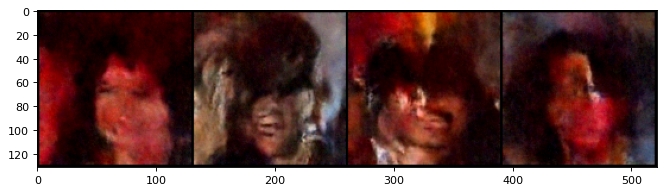

100%|██████████| 3165/3165 [07:46<00:00,  6.78it/s, LR=0.0002, MSE=0.0214] 


Random Seed:  999


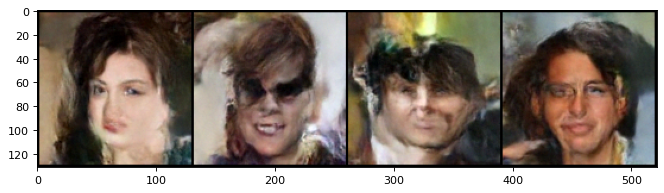

100%|██████████| 3165/3165 [07:46<00:00,  6.78it/s, LR=0.0002, MSE=0.0202] 


Random Seed:  999


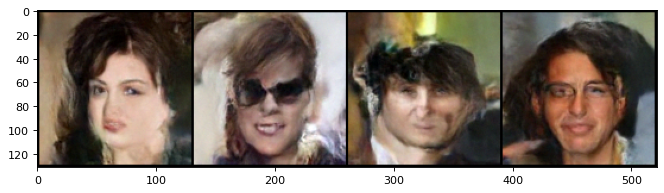

100%|██████████| 3165/3165 [07:47<00:00,  6.78it/s, LR=0.0002, MSE=0.0192] 


Random Seed:  999


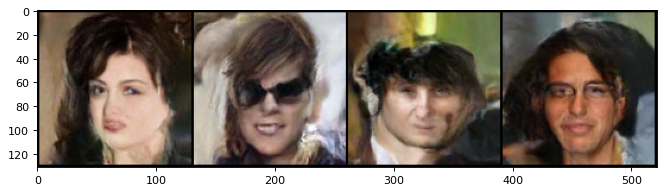

100%|██████████| 3165/3165 [07:47<00:00,  6.77it/s, LR=0.0002, MSE=0.0184] 


Random Seed:  999


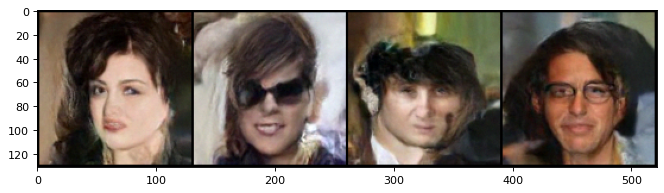

100%|██████████| 3165/3165 [07:47<00:00,  6.78it/s, LR=0.0002, MSE=0.0181] 


Random Seed:  999


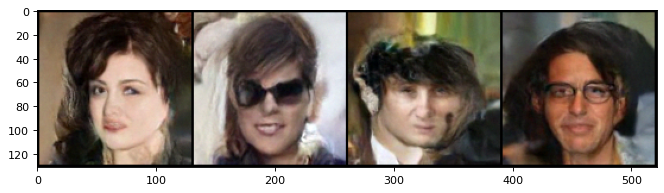

100%|██████████| 3165/3165 [07:47<00:00,  6.78it/s, LR=0.0002, MSE=0.0174] 


Random Seed:  999


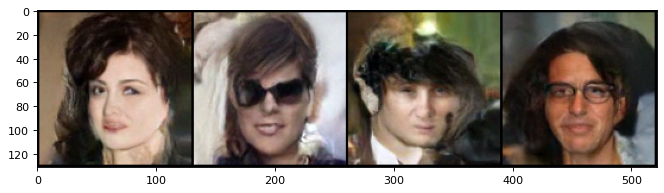

100%|██████████| 3165/3165 [07:47<00:00,  6.77it/s, LR=0.0002, MSE=0.0173] 


Random Seed:  999


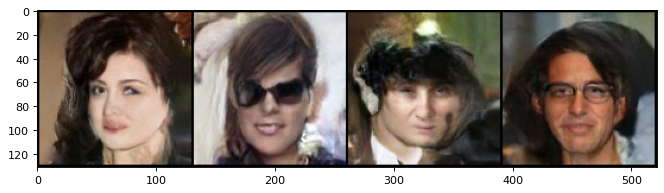

100%|██████████| 3165/3165 [07:46<00:00,  6.78it/s, LR=0.0002, MSE=0.017]  


Random Seed:  999


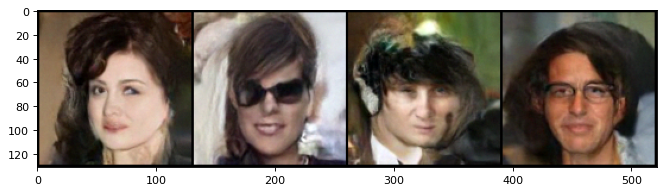

100%|██████████| 3165/3165 [07:48<00:00,  6.76it/s, LR=0.0002, MSE=0.0167] 


Random Seed:  999


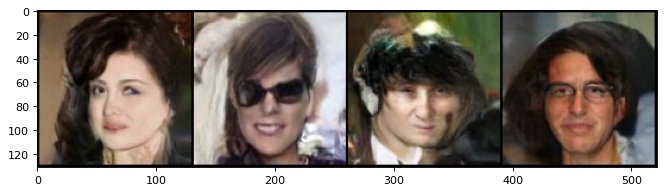

In [10]:
model = UNet().to(device)
ema_model = deepcopy(model)
ema = EMA()
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
scaler = torch.cuda.amp.GradScaler()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
diffusion = Diffusion(img_size=image_size, device=device)

for epoch in range(10):
    pbar = tqdm(trainloader)
    for images, y in pbar:
        
        ll = (2*y[:,gender_index].view(-1).cuda()+y[:,glasses_index].view(-1).cuda())
        
        with torch.cuda.amp.autocast(enabled=True):
            images = images.to(device)
            
            
            t = torch.randint(low = 1, high = diffusion.num_timesteps, size = (len(y),)).to(device)
            
            x_t, noise = diffusion.get_noisy_image(images, t)
            predicted_noise = model(x_t, t, ll)
            
            
            loss = F.mse_loss(predicted_noise, noise)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        pbar.set_postfix(MSE=loss.item(), LR=optimizer.param_groups[0]['lr'])
        
        if epoch > 0:
            ema.step_ema(ema_model, model)
            
    if epoch == 0:
        ema_model = deepcopy(model)
        
    set_random_seed()
    sampled_images = diffusion.sample(ema_model, n=4, y=torch.tensor([0,1,2,3]).cuda())
    show_images(sampled_images)

Random Seed:  995


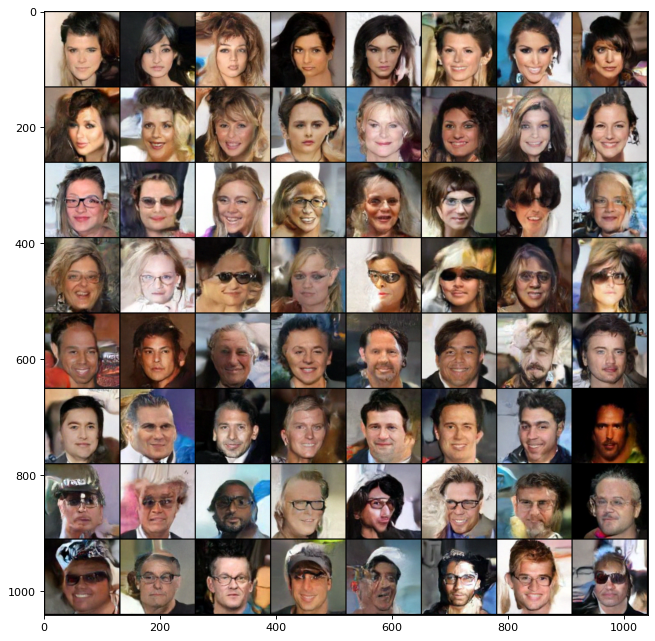

In [14]:
set_random_seed(995)
y_gender = torch.cat((torch.zeros(16, dtype=torch.long), torch.ones(16, dtype=torch.long), 2*torch.ones(16, dtype=torch.long), 3*torch.ones(16, dtype=torch.long)))
sampled_images = diffusion.sample(ema_model, n=64, y=y_gender.cuda())
show_images(sampled_images)

In [12]:
torch.save((ema_model.state_dict(), model.state_dict()), 'conditional.pt')
ema_model_state_dict, model_state_dict = torch.load('conditional.pt')
ema_model.load_state_dict(ema_model_state_dict)
model.load_state_dict(model_state_dict)

<All keys matched successfully>